<img src="Python.png" width="200">

# Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from geopy.distance import distance # needs to be downloaded with pip (pip3 install geopy)

# Pre-processing

## Defining data sources

In [2]:
URL_LISTINGS = "http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-12-17/visualisations/listings.csv"
URL_LISTINGS_DETAILED = "http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-12-17/data/listings.csv.gz"
URL_REVIEWS = "http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-12-17/visualisations/reviews.csv"
URL_REVIEWS_DETAILED = "http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-12-17/data/reviews.csv.gz"
URL_CALENDAR = "http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-12-17/data/calendar.csv.gz"
URL_NEIGHBOURHOODS = "http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-12-17/visualisations/neighbourhoods.csv"
URL_NEIGHBOURHOODS_GEO = "http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-12-17/visualisations/neighbourhoods.geojson"

## Loading data sets into pandas

In [3]:
df_listings = pd.read_csv(URL_LISTINGS)
df_listings_detailed = pd.read_csv(URL_LISTINGS_DETAILED, compression='gzip')
# df_reviews = pd.read_csv(URL_REVIEWS)
# df_reviews_detailed = pd.read_csv(URL_REVIEWS_DETAILED, compression='gzip')
df_calendar = pd.read_csv(URL_CALENDAR, compression='gzip')
df_neighbourhoods = pd.read_csv(URL_NEIGHBOURHOODS)

In [4]:
dfc_listings = df_listings.copy()
dfc_listings_detailed = df_listings_detailed.copy()
#dfc_reviews = df_reviews.copy()
#dfc_reviews_detailed = df_reviews_detailed.copy()
dfc_calendar = df_calendar.copy()
dfc_neighbourhoods = df_neighbourhoods.copy()

## Data Exploration

Let us have a look at the dataset. First of all we want to know the size, the columns and the type of the dataset.

In [5]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20352 entries, 0 to 20351
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20352 non-null  int64  
 1   name                            20349 non-null  object 
 2   host_id                         20352 non-null  int64  
 3   host_name                       20347 non-null  object 
 4   neighbourhood_group             20352 non-null  object 
 5   neighbourhood                   20352 non-null  object 
 6   latitude                        20352 non-null  float64
 7   longitude                       20352 non-null  float64
 8   room_type                       20352 non-null  object 
 9   price                           20352 non-null  int64  
 10  minimum_nights                  20352 non-null  int64  
 11  number_of_reviews               20352 non-null  int64  
 12  last_review                     

Secoundly a statistical description helps to give a feeling for the dataset. Here we only choose coloums for which this description makes sense.

In [6]:
df_listings[['price','minimum_nights','number_of_reviews','calculated_host_listings_count', 'availability_365']].describe(include='all')

price  minimum_nights  number_of_reviews  \
count  20352.000000    20352.000000       20352.000000   
mean     115.756732        6.120381          31.665537   
std      354.502984       30.964229          63.130360   
min        0.000000        1.000000           0.000000   
25%       35.000000        1.000000           0.000000   
50%       59.000000        2.000000           4.000000   
75%      100.000000        3.000000          32.000000   
max     9999.000000     1125.000000         678.000000   

       calculated_host_listings_count  availability_365  
count                    20352.000000      20352.000000  
mean                        11.183471        153.010711  
std                         28.264229        149.119819  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          2.000000         90.000000  
75%                          7.000000        340.000000  
max                        197.000000        365.000000

## Outliers

In [7]:
def removeOutliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 *IQR)
    df.loc[filter].drop(axis = 1)

def plotBoxplot (df, columns):
    fig = plt.figure(figsize=(15, 6))

    for column1 in columns:
        fig.add_subplot(1,len(columns),columns.index(column1)+1).boxplot(column = column1)

    return fig  
        


(20352, 16)
(9362, 16)
365


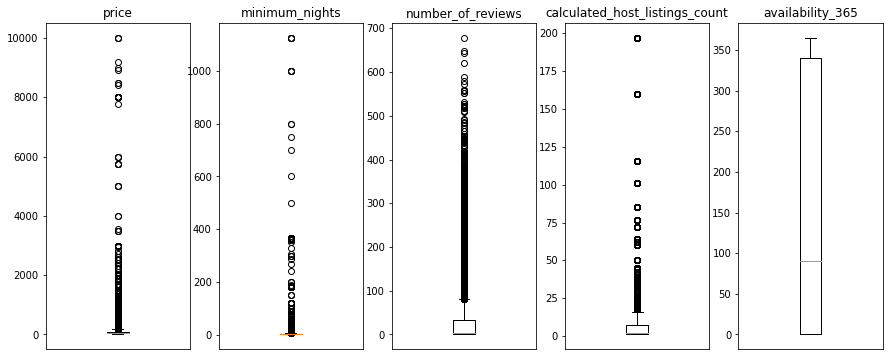

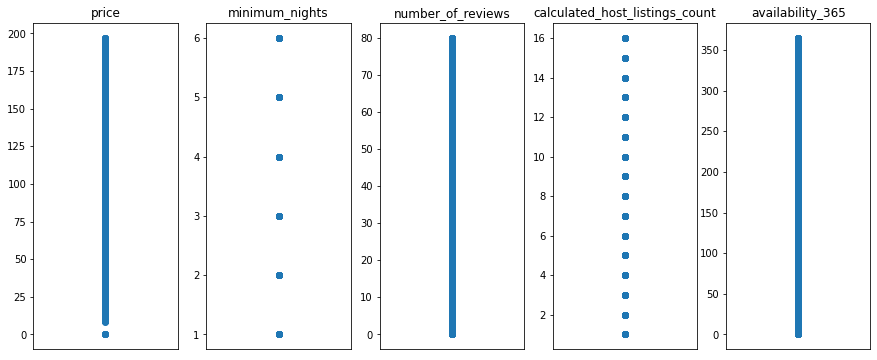

In [8]:
fig1 = plt.figure(figsize=(15, 6))
ax1 = fig1.add_subplot(1,5,1)
ax2 = fig1.add_subplot(1,5,2)
ax3 = fig1.add_subplot(1,5,3)
ax4 = fig1.add_subplot(1,5,4)
ax5 = fig1.add_subplot(1,5,5)

ax1.boxplot(dfc_listings['price'])
ax1.set_title('price')
ax1.get_xaxis().set_visible(False)

ax2.boxplot(dfc_listings['minimum_nights'])
ax2.set_title('minimum_nights')
ax2.get_xaxis().set_visible(False)

ax3.boxplot(dfc_listings['number_of_reviews'])
ax3.set_title('number_of_reviews')
ax3.get_xaxis().set_visible(False)

ax4.boxplot(dfc_listings['calculated_host_listings_count'])
ax4.set_title('calculated_host_listings_count')
ax4.get_xaxis().set_visible(False)

ax5.boxplot(dfc_listings['availability_365'])
ax5.set_title('availability_365')
ax5.get_xaxis().set_visible(False)

fig1.show()


#removing outliers
print(dfc_listings.shape)

sorted(dfc_listings)

Q1=dfc_listings.quantile(0.25)
Q3=dfc_listings.quantile(0.75)
IQR=Q3-Q1

dfc_listings_cleared = dfc_listings[~((dfc_listings < (Q1 - 1.5 * IQR)) |(dfc_listings > (Q3 + 1.5 * IQR))).any(axis=1)]

print(dfc_listings_cleared.shape)
print(max(dfc_listings_cleared['availability_365']))

fig2 = plt.figure(figsize=(15, 6))
ax1 = fig2.add_subplot(1,5,1)
ax2 = fig2.add_subplot(1,5,2)
ax3 = fig2.add_subplot(1,5,3)
ax4 = fig2.add_subplot(1,5,4)
ax5 = fig2.add_subplot(1,5,5)

ax1.scatter([0]* len(dfc_listings_cleared), dfc_listings_cleared['price'])
ax1.set_title('price')
ax1.get_xaxis().set_visible(False)

ax2.scatter([0]* len(dfc_listings_cleared), dfc_listings_cleared['minimum_nights'])
ax2.set_title('minimum_nights')
ax2.get_xaxis().set_visible(False)

ax3.scatter([0]* len(dfc_listings_cleared), dfc_listings_cleared['number_of_reviews'])
ax3.set_title('number_of_reviews')
ax3.get_xaxis().set_visible(False)

ax4.scatter([0]* len(dfc_listings_cleared), dfc_listings_cleared['calculated_host_listings_count'])
ax4.set_title('calculated_host_listings_count')
ax4.get_xaxis().set_visible(False)

ax5.scatter([0]* len(dfc_listings_cleared), dfc_listings_cleared['availability_365'])
ax5.set_title('availability_365')
ax5.get_xaxis().set_visible(False)

fig2.show()

#TODO for availability_365 the this makes not to much sense


# Feature Engineering

We now want to engineer a new feature (variable) in our dataset. Since we are looking at an airbnb dataset and we estimate that most of airbnb customers are there for touristic purposes we assume the distance to the city center (and most touristic attractions) is an important factor for the airbnb prize. We can use the latitude and longitude of the airbnb listings to calculate the distance to the coordinates of the geographical city center. 

In [9]:
# We are using the overpass api to access OpenStreetMap data and to get the coordinates of the city center. We assume that our search string is specific enough
def getCityCoordinates(searchString):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
        [out:json];
        node["name"={searchString}]["place"="city"];
        out center;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    city = response.json()['elements'][0]
    return city['lat'], city['lon']

#Uses geopy to calculate the distance between two points defined by their coordinates
def getDistance(fromPoint, toPoint):
    return distance(fromPoint, toPoint).m


In [10]:
coordinatesMadrid = getCityCoordinates("Madrid")

dfc_listings["distance_to_center"] = dfc_listings.apply(lambda row: getDistance(coordinatesMadrid, (row["latitude"], row["longitude"])), axis=1)

<AxesSubplot:>

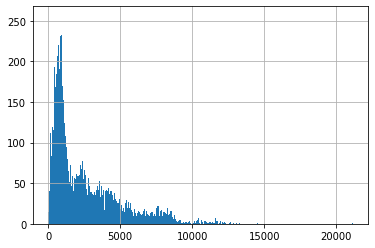

In [11]:
dfc_listings["distance_to_center"].hist(bins = 1000)

# Visualizing Location